# Loading the libs

In [1]:
import os
import numpy as np
import string
import pandas as pd
import math
import utils
import swifter
import operator
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from copy import deepcopy

import sklearn
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric

/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Downloading nltk corpus

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/simon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/simon/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [5]:
stopword = set(stopwords.words('english'))
punctuat = set(string.punctuation)

In [6]:
data = utils.load_data()

In [8]:
def visualize(label):
  words = ''
  for msg in data[data['type'] == label]['text']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

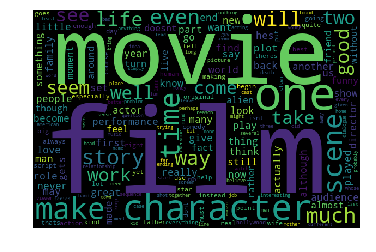

In [9]:
visualize('pos')

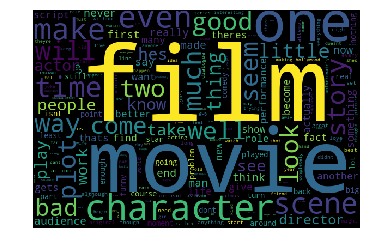

In [10]:
visualize('neg')

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

In [12]:
def get_score(index, score, matrix, order):
    X_ = matrix[index]
    indexes = (X_ >= score).nonzero()
    indexes[1].tolist()
    scores = []
    for value in indexes[1]:
        scores.append((vectorizer.get_feature_names()[value], matrix[index, value]))
    scores = sorted(scores, key=lambda tup: tup[1])
    if order == 'ascending':
        return scores
    elif order == 'descending':
        return scores[::-1]

In [13]:
get_score(0, 0.1, X, 'descending')

[('buddy', 0.3490991934305151),
 ('bud', 0.30305374608030855),
 ('snively', 0.25652166359704354),
 ('air', 0.20802042781660093),
 ('basketball', 0.17209769460087943),
 ('the', 0.16226707875234198),
 ('kevins', 0.1410361029857222),
 ('dog', 0.12136670538635254),
 ('kevin', 0.11241449091476925),
 ('pet', 0.11174432285019446),
 ('to', 0.10828623060364227)]

In [14]:
threshold = np.linspace(start = 0.0, stop = 1.0, num = 25)
threshold

array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])

In [9]:
vectorizer.vocabulary_['bob']

4927

In [85]:
# For each words, if the word is in the word dictionary that we have previously created, we keep it, discard it if not. 
WORD_DICT = vectorizer.get_feature_names()
def filter_words(s, X, threshold):
    words = []
    idf = X
    for w in s:
        if w in vectorizer.vocabulary_ and idf[0, vectorizer.vocabulary_[w]] > threshold:
            words.append(w)
    return words

In [87]:
def newData(thresholds, X):
    data = utils.load_data()
    data['idf'] = ''
    for i in data.index:
        data.loc[i]['idf'] = X[i] 
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
    # Tokenizing texts
    data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))
    # filtering word from the dictionary
    data['preprocess'] = data.apply(lambda x: filter_words(x['preprocess'], x['idf'], thresholds), axis=1)
    # Transforming array of string into a single string
    data['text'] = data['preprocess'].swifter.apply(lambda x : ' '.join(word for word in x))
    return data

In [88]:
newData(thresholds=0.1, X=X)

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 157370.00it/s]


,text,type,idf,preprocess
0,mummy fraser mummy sommers rough rough fraser ...,pos,"(0, 4927)\t0.04730071820445292\n (0, 42188)...","[mummy, fraser, mummy, sommers, rough, rough, ..."
1,today war reality priivate ryan steve spielber...,pos,"(0, 42188)\t0.2336455822846404\n (0, 20892)...","[today, war, reality, priivate, ryan, steve, s..."
2,jim carrey truman truman world truman jim carr...,pos,"(0, 42188)\t0.3151491601181007\n (0, 20892)...","[jim, carrey, truman, truman, world, truman, j..."
3,crazybeautiful afterschool crazybeautiful paci...,pos,"(0, 42188)\t0.32583095727651\n (0, 20892)\t...","[crazybeautiful, afterschool, crazybeautiful, ..."
4,mission hunt mission impossible phelps ethan h...,pos,"(0, 42188)\t0.32546247133721334\n (0, 20892...","[mission, hunt, mission, impossible, phelps, e..."
5,starship troopers ready rico ready enlisted en...,pos,"(0, 42188)\t0.29717655318040337\n (0, 20892...","[starship, troopers, ready, rico, ready, enlis..."
6,disney mulan mulan disney mulans mulan mulans ...,pos,"(0, 42188)\t0.26667240322115016\n (0, 20892...","[disney, mulan, mulan, disney, mulans, mulan, ..."
7,queen garofalo queen matchmaker garofalo marcy...,pos,"(0, 42188)\t0.2765083757909284\n (0, 20892)...","[queen, garofalo, queen, matchmaker, garofalo,..."
8,ant bugs life antz bugs life life ant flik fli...,pos,"(0, 42188)\t0.27102636272157865\n (0, 20892...","[ant, bugs, life, antz, bugs, life, life, ant,..."
9,disney animated disneys animated disney animat...,pos,"(0, 42188)\t0.43463438236739566\n (0, 20892...","[disney, animated, disneys, animated, disney, ..."


In [15]:
def find_threshold(model, thresholds, X, y):
    test_accuracy = []
    train_accuracy = []
    for thresh in thresholds:
        X__ = deepcopy(X)
        X__[X__ < thresh] = 0
        X_train, X_test, y_train, y_test = train_test_split(X__, y, test_size = 0.33)
        model.fit(X_train, y_train)
        print("threshold : {}".format(thresh))
        #print("Training accuracy : {}".format(model.score(X_train, y_train)))
        train_accuracy.append(model.score(X_train, y_train))
        #print("Test accuracy : {}".format(model.score(X_test, y_test)))
        test_accuracy.append(model.score(X_test, y_test))
        #print("Classification report for test set")
        #print(classification_report(y_test, model.predict(X_test)))
    return test_accuracy, train_accuracy

In [16]:
model = MultinomialNB()
ta, tra = find_threshold(model, threshold, X, y)

threshold : 0.0
threshold : 0.041666666666666664
threshold : 0.08333333333333333
threshold : 0.125
threshold : 0.16666666666666666
threshold : 0.20833333333333331
threshold : 0.25
threshold : 0.29166666666666663
threshold : 0.3333333333333333
threshold : 0.375
threshold : 0.41666666666666663
threshold : 0.4583333333333333
threshold : 0.5
threshold : 0.5416666666666666
threshold : 0.5833333333333333
threshold : 0.625
threshold : 0.6666666666666666
threshold : 0.7083333333333333
threshold : 0.75
threshold : 0.7916666666666666
threshold : 0.8333333333333333
threshold : 0.875
threshold : 0.9166666666666666
threshold : 0.9583333333333333
threshold : 1.0


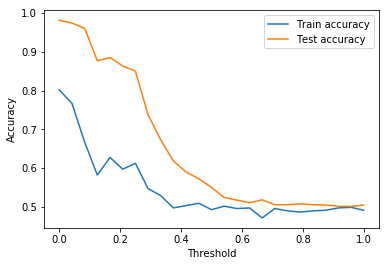

In [17]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
ta, tra = find_threshold(model, threshold, X, y)

threshold : 0.0
threshold : 0.041666666666666664
threshold : 0.08333333333333333
threshold : 0.125
threshold : 0.16666666666666666
threshold : 0.20833333333333331
threshold : 0.25
threshold : 0.29166666666666663
threshold : 0.3333333333333333
threshold : 0.375
threshold : 0.41666666666666663
threshold : 0.4583333333333333
threshold : 0.5
threshold : 0.5416666666666666
threshold : 0.5833333333333333
threshold : 0.625
threshold : 0.6666666666666666
threshold : 0.7083333333333333
threshold : 0.75
threshold : 0.7916666666666666
threshold : 0.8333333333333333
threshold : 0.875
threshold : 0.9166666666666666
threshold : 0.9583333333333333
threshold : 1.0


In [ ]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that keeping all features perform better.

## Model Evaluation

### Kfolds - k = 10

In [7]:
utils.kfolds_tfidf(MultinomialNB(), data)

Train accuracy : 0.9629999999999999
Test accuracy : 0.8074999999999999
[0.81, 0.76, 0.815, 0.74, 0.855, 0.83, 0.805, 0.825, 0.785, 0.85]


In [9]:
utils.kfolds_tfidf(RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1), data)

Train accuracy : 1.0
Test accuracy : 0.8160000000000001
[0.78, 0.815, 0.825, 0.845, 0.795, 0.84, 0.8, 0.81, 0.805, 0.845]


### Confusion matrix

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [16]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, n_jobs = -1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
print("True Positive : {}, \t False Positive : {} \nTrue Negative : {}, \t False Negative : {}".format(tp, fp, tn, fn))

Training accuracy : 1.0
Test accuracy : 0.8121212121212121
Classification report for test set
             precision    recall  f1-score   support

        neg       0.85      0.79      0.82       354
        pos       0.77      0.84      0.81       306

avg / total       0.82      0.81      0.81       660

True Positive : 257, 	 False Positive : 75 
True Negative : 279, 	 False Negative : 49


In [20]:
model = MultinomialNB()
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
print("True Positive : {}, \t False Positive : {} \nTrue Negative : {}, \t False Negative : {}".format(tp, fp, tn, fn))

Training accuracy : 0.9791044776119403
Test accuracy : 0.793939393939394
Classification report for test set
             precision    recall  f1-score   support

        neg       0.79      0.81      0.80       334
        pos       0.80      0.78      0.79       326

avg / total       0.79      0.79      0.79       660

True Positive : 255, 	 False Positive : 65 
True Negative : 269, 	 False Negative : 71


### Testing on new data

In [23]:
df = pd.read_csv("Our_Data/text.csv", index_col=0)

In [24]:
texts = df['text'].tolist()

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, n_jobs = -1)
model.fit(X, y)
X_test = vectorizer.transform(texts)
print("Training accuracy : {}".format(model.score(X, y)))
df.assign(scores = model.predict(X_test))

Training accuracy : 1.0


,text,scores
id,,
1,About as exciting as a trip to Hogwarts's most...,pos
2,"More workmanlike than magical, 'Fantastic Beas...",pos
3,"Despite being light in the story department, T...",pos
4,With too much happening all at once and not en...,neg
5,Part Two of J.K. Rowling's latest franchise is...,pos
6,It's not only the film's boring lack of origin...,pos
7,It's always fun to decry a formulaic movie - e...,pos
8,Although 'Creed 2' doesn't have the same rousi...,pos
9,Merely adopting a formula is easy - that happe...,pos


In [26]:
model = MultinomialNB()
model.fit(X, y)
X_test = vectorizer.transform(texts)
print("Training accuracy : {}".format(model.score(X, y)))
df.assign(scores = model.predict(X_test))

Training accuracy : 0.96


,text,scores
id,,
1,About as exciting as a trip to Hogwarts's most...,neg
2,"More workmanlike than magical, 'Fantastic Beas...",pos
3,"Despite being light in the story department, T...",neg
4,With too much happening all at once and not en...,neg
5,Part Two of J.K. Rowling's latest franchise is...,pos
6,It's not only the film's boring lack of origin...,neg
7,It's always fun to decry a formulaic movie - e...,neg
8,Although 'Creed 2' doesn't have the same rousi...,pos
9,Merely adopting a formula is easy - that happe...,pos


In this case, Naïve-Bayes work a lot better than random forest classifier.

## Feature Selection with mutual information

In [9]:
data = utils.load_data()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

contigency = []
for text in data.iterrows():
    words_list = {}
    for word in vectorizer.get_feature_names():
        if word in text[1]['text']:
            words_list[word] = True
        else:
            words_list[word] = False
    contigency.append(words_list)
    
pos = pd.DataFrame(contigency[0:1000])
neg = pd.DataFrame(contigency[1000:2000])

In [10]:
pos.head()

,00,000,0009f,000acre,000aweek,000foot,000paltry,007,007esque,00s,...,zuko,zukovsky,zulu,zundel,zurgs,zweibel,zwick,zwicks,zwigoffs,zycie
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
def getWordContigency(word, pos, neg):
    a = pos[word].value_counts()
    if True not in a:
        a = a.append(pd.Series([0], index=[True]))
    elif False not in a:
        a = a.append(pd.Series([0], index=[False]))
    b = neg[word].value_counts()
    if True not in b:
        b = b.append(pd.Series([0], index=[True]))
    elif False not in b:
        b = b.append(pd.Series([0], index=[False]))
    return [[a[True], b[True]], [a[False], b[False]]]

In [12]:
def getProbaWord(word, pos, neg):
    a = pos[word].value_counts()
    if True not in a:
        a[True] = 0
    elif False not in a:
        a[False] = 0
    b = neg[word].value_counts()
    if True not in b:
        b[True] = 0
    elif False not in b:
        b[False] = 0
    return a[True] + b[True] / 2000

In [13]:
def mutualInfo(matrix):
    proba = [[]]
    I = 0
    proba_word = [(matrix[0][0] + matrix[0][1]) / 2000, 1 - (matrix[0][0] + matrix[0][1]) / 2000]
    for i in range(0, 2):
        for j in range(0, 2):
            p = matrix[i][j] / 2000
            if math.isclose(p, 0, rel_tol = 1e-09):
                continue
            I += p * math.log2(p / (proba_word[i] * 1/2))
    return I

In [14]:
MI = {}
for word in vectorizer.get_feature_names():
    matrix = getWordContigency(word, pos, neg)
    MI[word] = mutualInfo(matrix)

Sorting all the word according to mutual information and taking the 2000 that have the biggest mutual information

In [30]:
sorted_x = sorted(MI.items(), key=operator.itemgetter(1))
WORD_DICT = [w[0] for w in sorted_x[-4001:-1]]

In [31]:
data.head()

,text,type,preprocess
0,alicia silverstone ride rising special taking ...,pos,"[alicia, silverstone, ride, rising, special, t..."
1,today war reality reality war reality hanks st...,pos,"[today, war, reality, reality, war, reality, h..."
2,hilarious takes world burbank world frankly wo...,pos,"[hilarious, takes, world, burbank, world, fran..."
3,addresses special worse young works performanc...,pos,"[addresses, special, worse, young, works, perf..."
4,sir takes notch gains beautiful finds sets plo...,pos,"[sir, takes, notch, gains, beautiful, finds, s..."


In [32]:
# For each words, if the word is in the word dictionary that we have previously created, we keep it, discard it if not. 
def filter_words(s):
    words = []
    for w in s:
        if w in WORD_DICT:
            words.append(w)
    return words

In [33]:
data = utils.load_data()
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
# Tokenizing texts
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))
# filtering word from the dictionary
data['preprocess'] = data['preprocess'].swifter.apply(lambda x: filter_words(x))
# Transforming array of string into a single string
data['text'] = data['preprocess'].swifter.apply(lambda x : ' '.join(word for word in x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 49607.67it/s]


In [34]:
model = MultinomialNB()
utils.kfolds_tfidf(model, data)

Train accuracy : 0.943
Test accuracy : 0.8969999999999999
[0.92, 0.89, 0.895, 0.92, 0.905, 0.895, 0.875, 0.87, 0.895, 0.905]


In [35]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
utils.kfolds_tfidf(model, data)

Train accuracy : 1.0
Test accuracy : 0.8404999999999999
[0.855, 0.8, 0.83, 0.855, 0.8, 0.895, 0.845, 0.825, 0.845, 0.855]


# Extra POS tagging

In [37]:
from nltk import pos_tag

In [38]:
data = utils.load_data()
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 2934.78it/s]


In [39]:
data['pos'] = data['preprocess'].swifter.apply(lambda x: pos_tag(x))
data['pos'] = data['pos'].swifter.apply(lambda x: [w[1] for w in x])
data['fd'] = data['pos'].swifter.apply(lambda x: nltk.FreqDist(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 5310.07it/s]


In [40]:
data.head()

,text,type,preprocess,pos,fd
0,bob the happy bastards quickie review \nthe m...,pos,"[bob, happy, bastards, quickie, review, mummy,...","[NN, JJ, NNS, NN, NN, NN, NN, NNS, VBD, JJ, NN...","{'NN': 68, 'JJ': 41, 'NNS': 22, 'VBD': 4, 'RBR..."
1,today war became a reality to me after seeing...,pos,"[today, war, reality, seeing, screening, savin...","[NN, NN, NN, VBG, VBG, VBG, NN, NN, VBP, NN, V...","{'NN': 43, 'VBG': 7, 'VBP': 6, 'VBZ': 2, 'JJS'..."
2,who would have thought \njim carrey does dram...,pos,"[thought, jim, carrey, drama, saw, advertiseme...","[VBN, NNS, JJ, NN, VBD, JJ, NN, VBD, JJ, NN, N...","{'VBN': 6, 'NNS': 40, 'JJ': 59, 'NN': 114, 'VB..."
3,crazybeautiful suffers from the damnedifyou...,pos,"[crazybeautiful, suffers, damnedifyoudo, damne...","[JJ, NNS, VBP, JJ, JJ, NN, NN, NN, JJ, NNS, JJ...","{'JJ': 62, 'NNS': 41, 'VBP': 15, 'NN': 97, 'VB..."
4,well this is not mission difficult mr hun...,pos,"[mission, difficult, mr, hunt, mission, imposs...","[NN, JJ, NN, NN, NN, JJ, JJ, NN, NN, NN, NN, N...","{'NN': 137, 'JJ': 69, 'VBZ': 16, 'VBD': 10, 'V..."


In [41]:
POS_set = set()
for row in data.iterrows():
    for tag in row[1]['pos']:
        POS_set.add(tag)

In [42]:
def updateSet(x):
    for tag in POS_set:
        if not tag in x:
            x[tag] = 0
    tab = [x[tag] for tag in sorted(POS_set)]
    return tab

In [43]:
data['fd'] = data['fd'].swifter.apply(lambda x: updateSet(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 49115.36it/s]


In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [45]:
X = data['fd'].tolist()
y = data['type'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 0.6037313432835821
Test accuracy : 0.5515151515151515
Classification report for test set
             precision    recall  f1-score   support

        neg       0.55      0.55      0.55       332
        pos       0.55      0.55      0.55       328

avg / total       0.55      0.55      0.55       660



In [46]:
X = data['fd'].tolist()
y = data['type'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 10), random_state=1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 0.6164179104477612
Test accuracy : 0.5909090909090909
Classification report for test set
             precision    recall  f1-score   support

        neg       0.58      0.65      0.62       333
        pos       0.60      0.53      0.56       327

avg / total       0.59      0.59      0.59       660



In [47]:
X = data['fd'].tolist()
y = data['type'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
model = MultinomialNB()
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 0.594776119402985
Test accuracy : 0.5772727272727273
Classification report for test set
             precision    recall  f1-score   support

        neg       0.57      0.56      0.57       324
        pos       0.58      0.59      0.59       336

avg / total       0.58      0.58      0.58       660



In [23]:
contigency = []
for text in data.iterrows():
    words_list = {}
    for tag in POS_set:
        if tag in text[1]['pos']:
            words_list[tag] = True
        else:
            words_list[tag] = False
    contigency.append(words_list)

In [24]:
def getWordContigency(tag, pos, neg):
    a = pos[tag].value_counts()
    if True not in a:
        a = a.append(pd.Series([0], index=[True]))
    elif False not in a:
        a = a.append(pd.Series([0], index=[False]))
    b = neg[tag].value_counts()
    if True not in b:
        b = b.append(pd.Series([0], index=[True]))
    elif False not in b:
        b = b.append(pd.Series([0], index=[False]))
    return [[a[True], b[True]], [a[False], b[False]]]

In [25]:
def mutualInfo(matrix):
    proba = [[]]
    I = 0
    proba_word = [(matrix[0][0] + matrix[0][1]) / 2000, 1 - (matrix[0][0] + matrix[0][1]) / 2000]
    for i in range(0, 2):
        for j in range(0, 2):
            p = matrix[i][j] / 2000
            if math.isclose(p, 0, rel_tol = 1e-09):
                continue
            I += p * math.log2(p / (proba_word[i] * 1/2))
    return I

In [26]:
pos = pd.DataFrame(contigency[0:1000])
neg = pd.DataFrame(contigency[1000:2000])

In [27]:
MI = {}
for tag in POS_set:
    matrix = getWordContigency(tag, pos, neg)
    MI[tag] = mutualInfo(matrix)

In [29]:
sorted_x = sorted(MI.items(), key=operator.itemgetter(1))

In [30]:
sorted_x

[('RB', -1.2813706015259676e-18),
 ('EX', 0.0),
 ('NNS', 0.0),
 ('SYM', 0.0),
 ('JJ', 0.0),
 ('NN', 0.0),
 ('VBG', 0.0),
 ('PRP', 4.533717028935228e-06),
 ('WDT', 1.0489916067016433e-05),
 ('CD', 1.7154311217477047e-05),
 ('JJR', 2.6798812094052347e-05),
 ('CC', 4.159577174267146e-05),
 ('RP', 6.729483782431673e-05),
 ('RBR', 8.792009740304311e-05),
 ('IN', 0.00010535036955963001),
 ('VBD', 0.00012273685671753066),
 ('PRP$', 0.00015508561070772062),
 ('WRB', 0.0002584822947280527),
 ('NNP', 0.0002964800438240503),
 ('VBN', 0.0003404627467939632),
 ('WP', 0.00043973774415648854),
 ('TO', 0.00048070674311640155),
 ('VBZ', 0.0004807067431164769),
 ("''", 0.0005001804271010232),
 ('JJS', 0.0005012921204565115),
 ('DT', 0.0006225288137355822),
 ('MD', 0.0006372792609078502),
 ('VBP', 0.0010007220697106993),
 ('VB', 0.0011033258571488194),
 ('UH', 0.0018524769246639943),
 ('FW', 0.0019442915712638495),
 ('POS', 0.0020028911743617357),
 ('NNPS', 0.0020028911743617357),
 ('PDT', 0.002504519726

In [57]:
top_set = [x[0] for x in sorted_x[-11:-1]]

In [58]:
top_set = set(top_set)

In [59]:
deleted_TAG = POS_set - top_set

In [66]:
top_set

{'DT', 'FW', 'JJS', 'MD', 'NNPS', 'PDT', 'POS', 'UH', 'VB', 'VBP'}

In [68]:
def updateSet(x):
    for tag in POS_set:
        if not tag in x:
            x[tag] = 0
    tab = [x[tag] for tag in sorted(top_set)]
    return tab

In [69]:
data['fd'] = data['fd'].swifter.apply(lambda x: updateSet(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 73259.75it/s]


In [74]:
X = data['fd'].tolist()
y = data['type'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 0.5694029850746268
Test accuracy : 0.5287878787878788
Classification report for test set
             precision    recall  f1-score   support

        neg       0.55      0.53      0.54       343
        pos       0.51      0.53      0.52       317

avg / total       0.53      0.53      0.53       660



In [73]:
X = data['fd'].tolist()
y = data['type'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 10), random_state=1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 0.5723880597014925
Test accuracy : 0.543939393939394
Classification report for test set
             precision    recall  f1-score   support

        neg       0.55      0.56      0.56       337
        pos       0.53      0.52      0.53       323

avg / total       0.54      0.54      0.54       660



In [71]:
X = data['fd'].tolist()
y = data['type'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
model = MultinomialNB()
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 0.5059701492537313
Test accuracy : 0.543939393939394
Classification report for test set
             precision    recall  f1-score   support

        neg       0.55      0.58      0.56       337
        pos       0.54      0.51      0.52       323

avg / total       0.54      0.54      0.54       660

